In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime, timedelta
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
import os
from google.colab import drive

# Get Data

SKIP THIS - this is used only if you are working inside colab 

In [0]:
drive.mount("/content/Drive/")
os.chdir('/content/Drive/My Drive/Colab Notebooks/covid19/')

Run this:

In [0]:
! python get_data.py

# Load Data

In [0]:
confirmed = pd.read_csv('data/time_series_19-covid-Confirmed.csv')
deaths = pd.read_csv('data/time_series_19-covid-Deaths.csv')
recover = pd.read_csv('data/time_series_19-covid-Recovered.csv')

In [0]:
day = datetime.today() - timedelta(days=2)

In [0]:
datastr = day.strftime('%m/%d')[1:] + '/20'

# Data transformation

In [0]:
confirmed_by_country = confirmed[['Country/Region', datastr]].groupby('Country/Region').sum().rename(columns={datastr: 'n_confirmed'})

In [0]:
deaths_by_country = deaths[['Country/Region', datastr]].groupby('Country/Region').sum().rename(columns={datastr: 'n_deaths'})

In [0]:
recover_by_country = recover[['Country/Region', datastr]].groupby('Country/Region').sum().rename(columns={datastr: 'n_recover'})

In [0]:
global_df = confirmed_by_country.merge(deaths_by_country, how='left', left_index=True, right_index=True).\
merge(recover_by_country, how='left', left_index=True, right_index=True)

In [0]:
confirmed_country_day = confirmed.drop(['Province/State', 'Lat', 'Long'], axis=1).groupby('Country/Region').sum()

In [0]:
recover_country_day = recover.drop(['Province/State', 'Lat', 'Long'], axis=1).groupby('Country/Region').sum()

In [0]:
deaths_country_day = deaths.drop(['Province/State', 'Lat', 'Long'], axis=1).groupby('Country/Region').sum()

In [0]:
ndays_since_first_confirmed = confirmed_country_day.apply(lambda x: (x > 0).sum(), axis=1)

In [0]:
ndays_since_first10_confirmed = confirmed_country_day.apply(lambda x: (x >= 10).sum(), axis=1)

In [0]:
ndays_since_first_death = deaths_country_day.apply(lambda x: (x > 0).sum(), axis=1)

In [0]:
ndays_since_first_recovery = recover_country_day.apply(lambda x: (x > 0).sum(), axis=1)

In [0]:
global_df = global_df.merge(ndays_since_first_confirmed.rename('days'), right_index=True, left_index=True)

In [0]:
global_df = global_df.merge(ndays_since_first_death.rename('ndays_since_first_death'), right_index=True, left_index=True)

In [0]:
global_df = global_df.merge(ndays_since_first_recovery.rename('ndays_since_first_recover'), right_index=True, left_index=True)

In [0]:
global_df = global_df.merge(ndays_since_first10_confirmed.rename('ndays_since_first10_confirmed'), right_index=True, left_index=True)

In [0]:
global_df['unk_state'] = global_df.n_confirmed-global_df.n_deaths-global_df.n_recover

# Analysis

In [0]:
print(f"{global_df.shape[0]} coutries with confirmed cases so far, {global_df.n_confirmed.sum()} confirmed cases, \
{global_df.n_deaths.sum()} deaths and {global_df.n_recover.sum()} recovers.")

116 coutries with confirmed cases so far, 125865 confirmed cases, 4615 deaths and 67003 recovers.


In [0]:
global_df.loc[['Italy', 'China', 'Spain', 'France', 'Netherlands', 'Portugal', 'Germany', 'United Kingdom'], 
              ['n_confirmed', 'days', 'ndays_since_first10_confirmed']]

,n_confirmed,days,ndays_since_first10_confirmed
Country/Region,,,
Italy,12462,42,21
China,80921,51,51
Spain,2277,41,16
France,2284,49,34
Netherlands,503,15,12
Portugal,59,11,7
Germany,1908,46,40
United Kingdom,459,42,18


In [0]:
colors = cm.get_cmap('tab20').colors

In [0]:
country_data = confirmed_country_day.loc['Portugal']
country_data = country_data[country_data>=10]

pt_days = len(country_data)

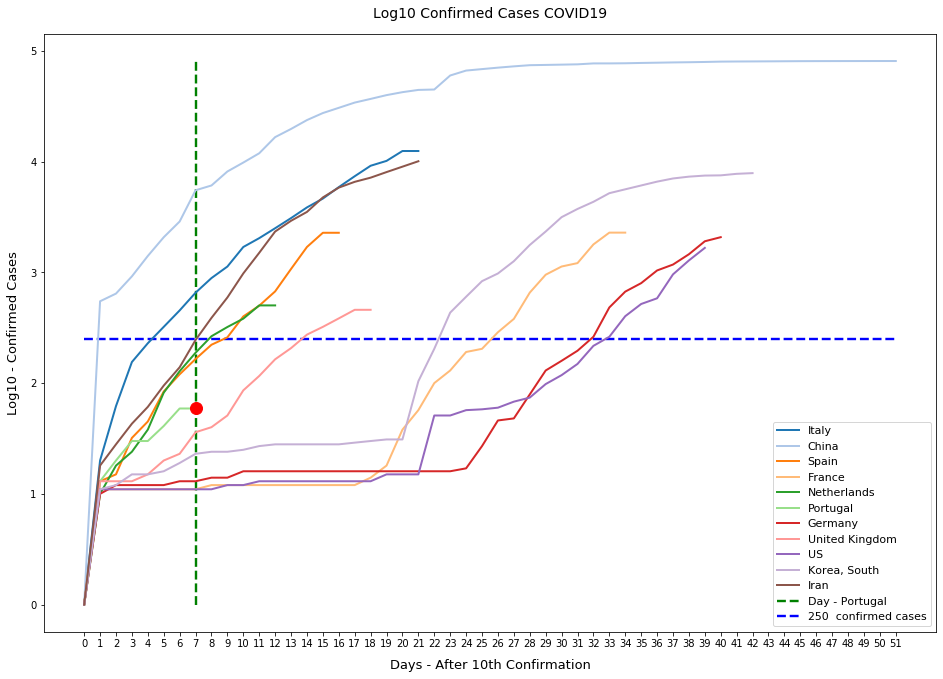

In [0]:
countries = ['Italy', 'China', 'Spain', 'France', 'Netherlands', 'Portugal', 'Germany', 'United Kingdom', 'US'
            , 'Korea, South', 'Iran']
max_total = 0
max_days = 0
plt.figure(figsize=(16,11))


for i, country in enumerate(countries):
    country_data = confirmed_country_day.loc[country]
    country_data = country_data[country_data>=10]
    
    if len(country_data.values) > max_days:
        max_days = len(country_data)
    
    vals = np.log10(country_data.values)
    maxval = vals.max()
    if maxval > max_total:
        max_total = maxval
    
    plt.plot(list(range(len(country_data)+1)), np.concatenate((np.array([0]),vals)), 
             label=country, color=colors[i], linewidth=2)
    
_ = plt.xticks(ticks=list(range(0,max_days+1)))
_ = plt.vlines(x=pt_days, ymin=0, ymax=max_total, linestyles='dashed', colors='g', label='Day - Portugal',
              linewidth=2.4)   

_ = plt.hlines(y=np.log10(250), xmin=0, xmax=max_days, linestyles='dashed', colors='b', label='250  confirmed cases',
              linewidth=2.4)  

_ = plt.legend(loc='lower right', fontsize=11)
_ = plt.title('Log10 Confirmed Cases COVID19', fontdict={'fontsize':14}, pad=16.0)
_ = plt.xlabel('Days - After 10th Confirmation', fontdict={'fontsize':13}, labelpad=10.0)
_ = plt.ylabel('Log10 - Confirmed Cases', fontdict={'fontsize':13}, labelpad=10.0)

country_data = confirmed_country_day.loc['Portugal']
country_data = country_data[country_data>=10]
_ = plt.plot(len(country_data), np.log10(country_data[-1]), 'ro', markersize=12)
plt.savefig('data/nconfirmed_log.png')

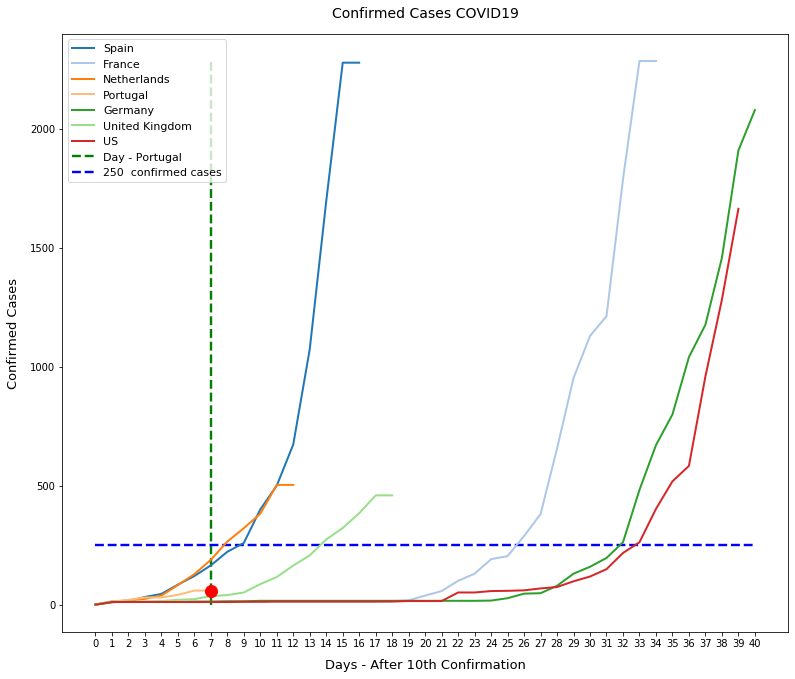

In [0]:
countries = ['Spain', 'France', 'Netherlands', 'Portugal', 'Germany', 'United Kingdom', 'US']
max_total = 0
max_days = 0

plt.figure(figsize=(13,11))

for i, country in enumerate(countries):
    country_data = confirmed_country_day.loc[country]
    country_data = country_data[country_data>=10]
    
    if len(country_data.values) > max_days:
        max_days = len(country_data)
    
    vals = country_data.values
    maxval = vals.max()
    if maxval > max_total:
        max_total = maxval
    
    plt.plot(list(range(len(country_data)+1)), np.concatenate((np.array([0]),vals)), 
             label=country, color=colors[i], linewidth=2)

_ = plt.xticks(ticks=list(range(0,max_days+1)))
_ = plt.vlines(x=pt_days, ymin=0, ymax=max_total, linestyles='dashed', colors='g', label='Day - Portugal',
              linewidth=2.4) 
_ = plt.hlines(y=250, xmin=0, xmax=max_days, linestyles='dashed', colors='b', label='250  confirmed cases',
              linewidth=2.4)  
_ = plt.legend(loc='upper left', fontsize=11)
_ = plt.title('Confirmed Cases COVID19', fontdict={'fontsize':14}, pad=16.0)
_ = plt.xlabel('Days - After 10th Confirmation', fontdict={'fontsize':13}, labelpad=10.0)
_ = plt.ylabel('Confirmed Cases', fontdict={'fontsize':13}, labelpad=10.0)

country_data = confirmed_country_day.loc['Portugal']
country_data = country_data[country_data>=10]
_ = plt.plot(len(country_data), country_data[-1], 'ro', markersize=12)
plt.savefig('data/nconfirmed_normal.png')

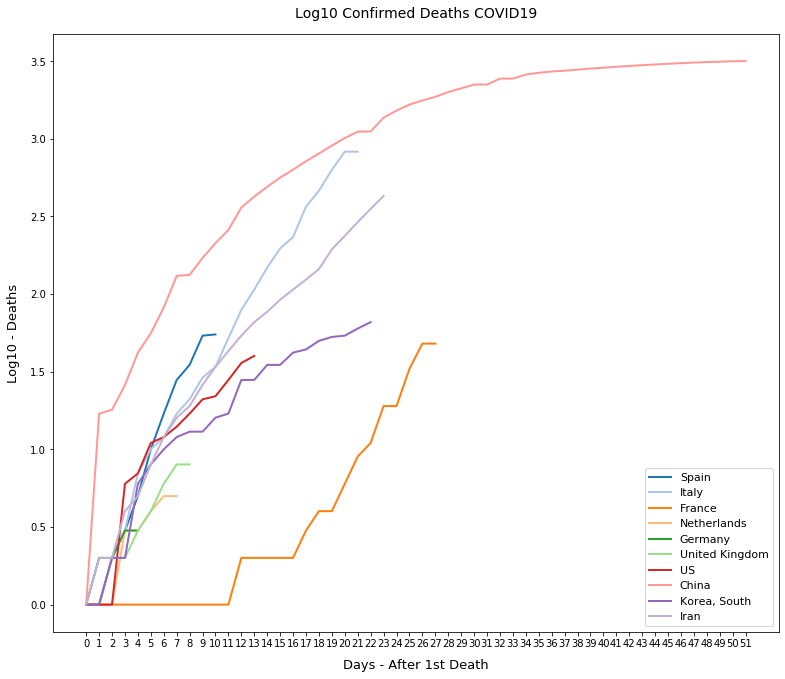

In [0]:
countries = ['Spain', 'Italy', 'France', 'Netherlands', 'Germany', 'United Kingdom', 'US', 'China', 
             'Korea, South', 'Iran']
max_total = 0
max_days = 0

plt.figure(figsize=(13,11))

for i, country in enumerate(countries):
    country_data = deaths_country_day.loc[country]
    country_data = country_data[country_data>=1]
    
    if len(country_data.values) > max_days:
        max_days = len(country_data)
    
    vals = np.log10(country_data.values)
    maxval = vals.max()
    if maxval > max_total:
        max_total = maxval
    
    plt.plot(list(range(len(country_data)+1)), np.concatenate((np.array([0]),vals)), 
             label=country, color=colors[i], linewidth=2)

_ = plt.xticks(ticks=list(range(0,max_days+1)))
_ = plt.legend(loc='lower right', fontsize=11)
_ = plt.title('Log10 Confirmed Deaths COVID19', fontdict={'fontsize':14}, pad=16.0)
_ = plt.xlabel('Days - After 1st Death', fontdict={'fontsize':13}, labelpad=10.0)
_ = plt.ylabel('Log10 - Deaths', fontdict={'fontsize':13}, labelpad=10.0)
plt.savefig('data/deathslog.png')

In [0]:
global_df.loc[['China', 'Italy'], 'n_deaths'] / global_df.loc[['China', 'Italy'], 'n_confirmed']

Country/Region
China    0.039063
Italy    0.066362
dtype: float64

# Models

In [0]:
def logistic(x, a, k):
    return 1 / (1 + np.exp(-k * (x - a)))

In [0]:
def exponential(x, z, k):
    return z**(x*k)

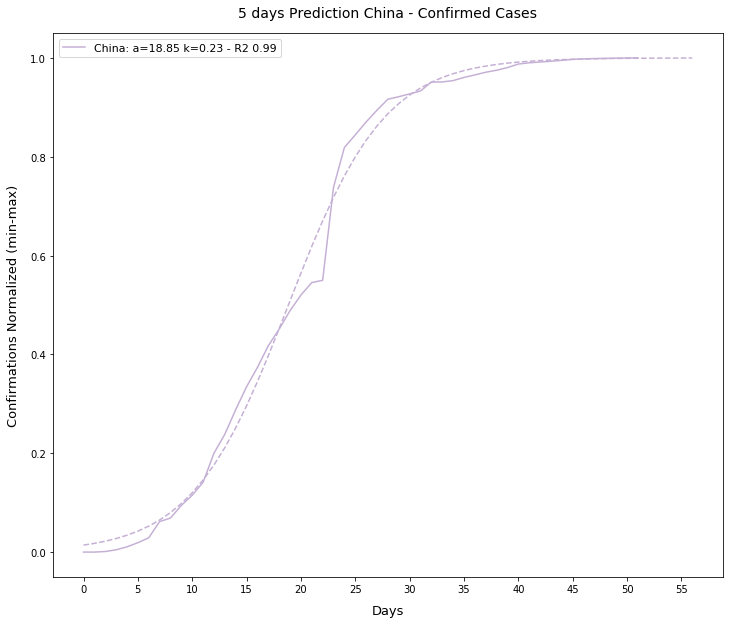

In [0]:
ndays_prev = 5
plt.figure(figsize=(12,10))

country_y = confirmed_country_day.loc['China']
country_y = (country_y - country_y.min()) / (country_y.max() - country_y.min())

country_y = np.concatenate((np.array([0]),country_y))
xdata_real = list(range(len(country_y)))

popt, pcov = curve_fit(logistic, xdata_real, country_y)
xdata_all = xdata_real + [i for i in range(xdata_real[-1], xdata_real[-1]+ndays_prev+1)]

prevs_to_plot = logistic(np.array(xdata_all), *popt)
predicted_func = logistic(np.array(xdata_real), *popt)
coefficient_of_dermination = r2_score(country_y,  predicted_func)


plt.plot(xdata_all, prevs_to_plot, linestyle='dashed', color=colors[i])
plt.plot(xdata_real, country_y, color=colors[i], \
         label=f"China: a={round(popt[0], 2)} k={round(popt[1], 2)} - R2 {round(coefficient_of_dermination,2)}")

_ = plt.xticks(ticks=[x for x in xdata_all if x%5 == 0])
plt.legend(loc='upper left', fontsize=11)
_ = plt.title('5 days Prediction China - Confirmed Cases', fontdict={'fontsize':14}, pad=16.0)
_ = plt.xlabel('Days', fontdict={'fontsize':13}, labelpad=10.0)
_ = plt.ylabel('Confirmations Normalized (min-max)', fontdict={'fontsize':13}, labelpad=10.0)
plt.savefig('data/modelchina.png')

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


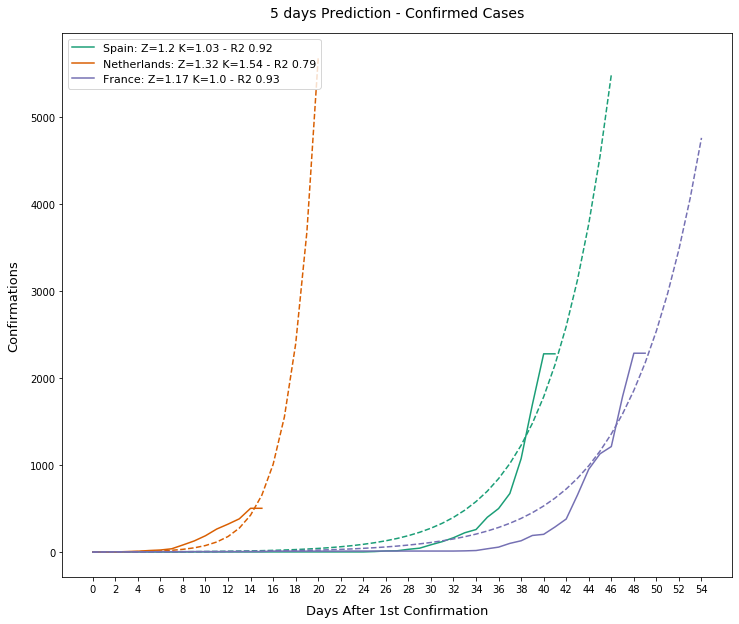

In [0]:
ndays_prev = 5
colors = cm.get_cmap('Dark2').colors
plt.figure(figsize=(12,10))
countries = ['Spain', 'Netherlands', 'France']
maximum = 0

for i, country_name in enumerate(countries):
    country_y = confirmed_country_day.loc[country_name]
    country_y = country_y[country_y>=1]
    
    country_y = np.concatenate((np.array([0]),country_y))
    xdata_real = list(range(len(country_y)))
    
    popt, pcov = curve_fit(exponential, xdata_real, country_y)
    xdata_all = xdata_real + [i for i in range(xdata_real[-1], xdata_real[-1]+ndays_prev+1)]
    
    if xdata_all[-1] > maximum:
        maximum = xdata_all[-1]
    
    prevs_to_plot = exponential(np.array(xdata_all), *popt)
    predicted_func = exponential(np.array(xdata_real), *popt)
    coefficient_of_dermination = r2_score(country_y,  predicted_func)

    
    plt.plot(xdata_all, prevs_to_plot, linestyle='dashed', color=colors[i])
    plt.plot(xdata_real, country_y, color=colors[i], \
             label=f"{country_name}: Z={round(popt[0], 2)} K={round(popt[1], 2)} - R2 {round(coefficient_of_dermination,2)}")
        
_ = plt.xticks(ticks=[i for i in range(0, maximum+1) if i % 2 == 0])
plt.legend(loc='upper left', fontsize=11)
_ = plt.title('5 days Prediction - Confirmed Cases', fontdict={'fontsize':14}, pad=16.0)
_ = plt.xlabel('Days After 1st Confirmation', fontdict={'fontsize':13}, labelpad=10.0)
_ = plt.ylabel('Confirmations', fontdict={'fontsize':13}, labelpad=10.0)
plt.savefig('data/modeleurope.png')

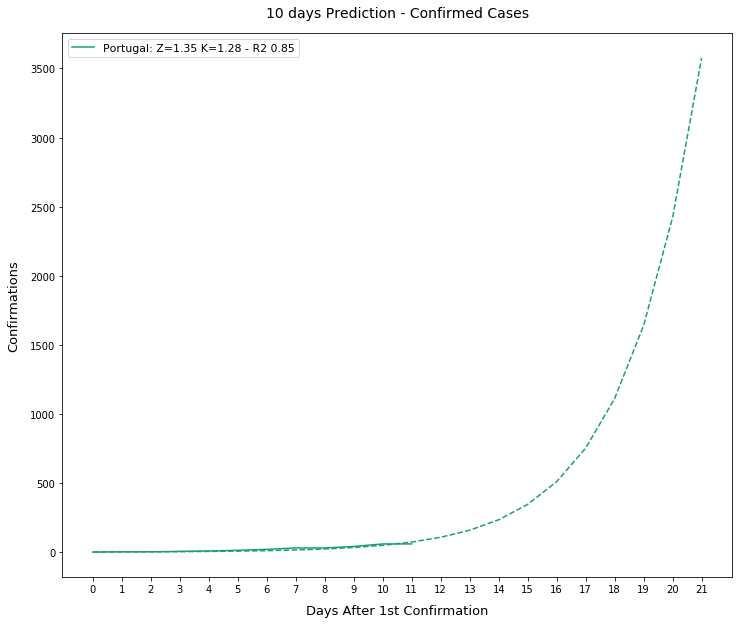

In [0]:
ndays_prev = 10
colors = cm.get_cmap('Dark2').colors
plt.figure(figsize=(12,10))
countries = ['Portugal']
maximum = 0

for i, country_name in enumerate(countries):
    country_y = confirmed_country_day.loc[country_name]
    country_y = country_y[country_y>=1]
    
    country_y = np.concatenate((np.array([0]),country_y))
    xdata_real = list(range(len(country_y)))
    
    popt, pcov = curve_fit(exponential, xdata_real, country_y)
    xdata_all = xdata_real + [i for i in range(xdata_real[-1], xdata_real[-1]+ndays_prev+1)]
    
    if xdata_all[-1] > maximum:
        maximum = xdata_all[-1]
    
    prevs_to_plot = exponential(np.array(xdata_all), *popt)
    predicted_func = exponential(np.array(xdata_real), *popt)
    coefficient_of_dermination = r2_score(country_y,  predicted_func)

    
    plt.plot(xdata_all, prevs_to_plot, linestyle='dashed', color=colors[i])
    plt.plot(xdata_real, country_y, color=colors[i], \
             label=f"{country_name}: Z={round(popt[0], 2)} K={round(popt[1], 2)} - R2 {round(coefficient_of_dermination,2)}")
        
_ = plt.xticks(ticks=list(range(0, maximum+1)))
plt.legend(loc='upper left', fontsize=11)
_ = plt.title('10 days Prediction - Confirmed Cases', fontdict={'fontsize':14}, pad=16.0)
_ = plt.xlabel('Days After 1st Confirmation', fontdict={'fontsize':13}, labelpad=10.0)
_ = plt.ylabel('Confirmations', fontdict={'fontsize':13}, labelpad=10.0)
plt.savefig('data/modelportugal.png')